In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# 1. Load the dataset   
df = pd.read_csv('expenses.csv')

In [9]:
# 2. Define features and target
X = df.drop('charges', axis=1)
y = df['charges']

In [10]:
# 3. Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [11]:
# 4. Preprocessing pipelines for numeric and categorical data
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [12]:
# 5. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [13]:
# --- Model 1: Linear Regression ---

# Create pipeline with preprocessing and model
linreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train model
linreg_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_linreg = linreg_pipeline.predict(X_test)
print('Linear Regression:')
print('MSE:', mean_squared_error(y_test, y_pred_linreg))
print('R²:', r2_score(y_test, y_pred_linreg))

Linear Regression:
MSE: 35479352.80730362
R²: 0.7623311844057112


In [14]:
# --- Model 2: Decision Tree Regression ---

# Pipeline for decision tree (no scaling needed, but we keep encoding)
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=1))
])

# Hyperparameter tuning for Decision Tree
param_grid = {
    'regressor__max_depth': [3, 5, 7, 10, None],
    'regressor__min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print('Decision Tree Regression:')
print('Best params:', grid_search.best_params_)

# Predict and evaluate
y_pred_dt = grid_search.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred_dt))
print('R²:', r2_score(y_test, y_pred_dt))

Decision Tree Regression:
Best params: {'regressor__max_depth': 3, 'regressor__min_samples_split': 2}
MSE: 20674679.862600364
R²: 0.8615046136150544


In [15]:
# --- Model 3: Lasso Regression with CV ---

# Pipeline for Lasso
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)

print('Lasso Regression:')
print('Best alpha:', lasso_pipeline.named_steps['regressor'].alpha_)

y_pred_lasso = lasso_pipeline.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred_lasso))
print('R²:', r2_score(y_test, y_pred_lasso))

Lasso Regression:
Best alpha: 3.8459663937893445
MSE: 35486825.73055277
R²: 0.7622811248449493


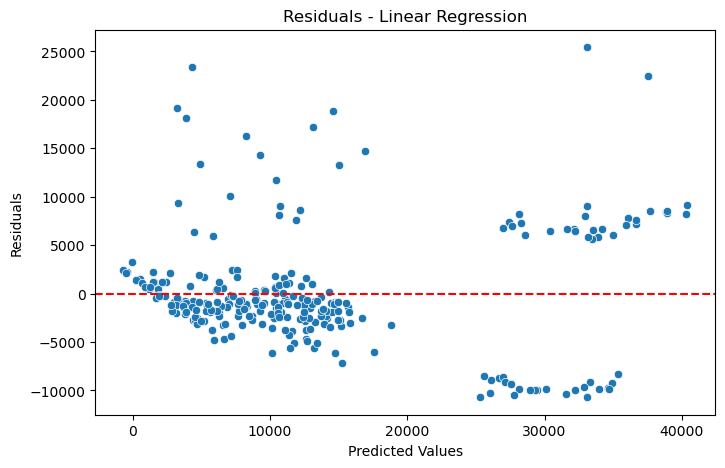

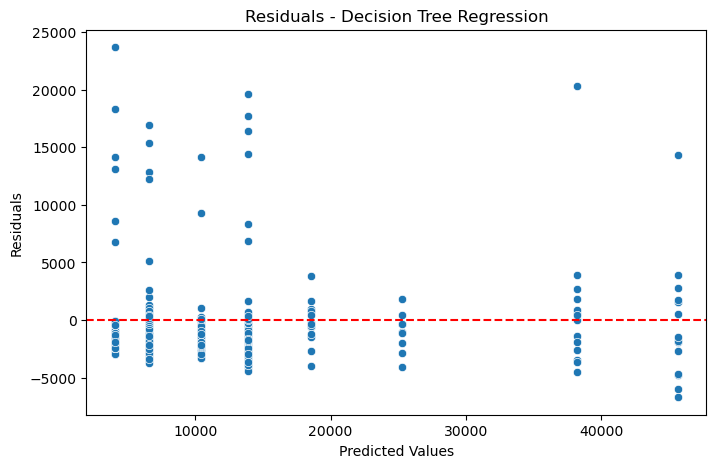

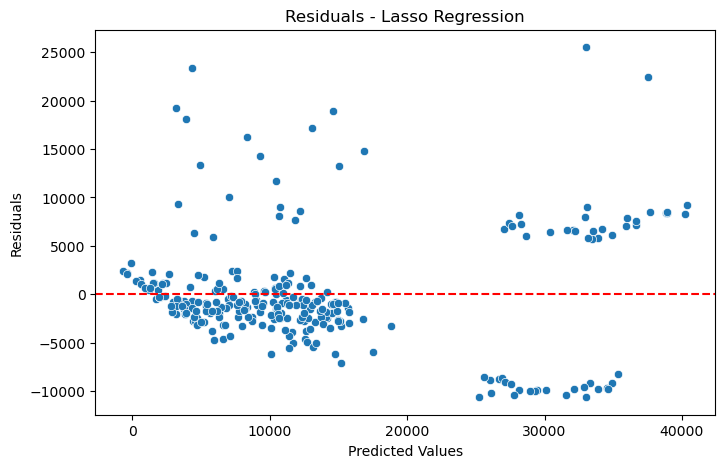

In [17]:
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.show()

# Plot residuals for all models
plot_residuals(y_test, y_pred_linreg, 'Residuals - Linear Regression')
plot_residuals(y_test, y_pred_dt, 'Residuals - Decision Tree Regression')
plot_residuals(y_test, y_pred_lasso, 'Residuals - Lasso Regression')